In [ ]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

# !pip install category_encoders
from category_encoders.leave_one_out import LeaveOneOutEncoder

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, fbeta_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, GridSearchCV, RandomizedSearchCV

from xgboost import XGBClassifier

# !pip install optuna
import optuna

In [ ]:
%matplotlib inline
sns.set_theme()

# Зафиксируем random_state
random_state = 2024

beta = 2

pd.set_option('display.max_columns', None)

In [ ]:
# https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
original_df = pd.read_csv('weatherAUS.csv')

In [ ]:
original_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129799,2017-05-18,Walpole,11.6,22.1,0.0,NaN,NaN,NNE,43.0,N,NW,7.0,17.0,69.0,57.0,1017.5,1014.0,NaN,NaN,14.3,20.9,No,Yes
129800,2017-05-19,Walpole,14.3,19.8,14.8,NaN,NaN,W,59.0,NNW,NW,15.0,24.0,99.0,84.0,1010.5,1005.8,NaN,NaN,16.7,17.5,Yes,Yes
129801,2017-05-20,Walpole,8.6,14.7,7.4,NaN,NaN,N,44.0,NW,NW,15.0,15.0,81.0,72.0,1012.3,1008.9,NaN,NaN,10.9,14.2,Yes,Yes
129802,2017-05-21,Walpole,10.0,13.6,9.4,NaN,NaN,NW,61.0,W,WSW,20.0,24.0,91.0,67.0,1002.3,1006.8,NaN,NaN,10.4,10.8,Yes,Yes


In [ ]:
original_df.describe(include='all')

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,129804,129804,128411.000000,128600.000000,126643.000000,71894.000000,66737.000000,119716,119774.000000,120111,125714,128083.000000,126795.000000,127266.000000,126167.000000,115906.000000,115944.000000,79034.000000,76195.000000,128101.000000,126938.000000,126642,126640
unique,3436,43,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2013-11-12,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,N,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,43,3436,NaN,NaN,NaN,NaN,NaN,9465,NaN,10744,9565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97716,97714
mean,NaN,NaN,11.951767,22.854884,2.363272,5.334228,7.543435,NaN,39.923331,NaN,NaN,14.061226,18.724776,69.794077,52.406144,1018.023605,1015.712377,4.511122,4.551900,16.699775,21.359602,NaN,NaN
std,NaN,NaN,6.136055,6.844201,8.370070,4.206186,3.809845,NaN,13.660476,NaN,NaN,9.000448,8.970721,18.356578,20.444790,6.985733,6.867305,2.881606,2.715779,6.175975,6.666632,NaN,NaN
min,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,7.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-7.200000,-5.400000,NaN,NaN
25%,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.700000,NaN,30.000000,NaN,NaN,7.000000,13.000000,58.000000,38.000000,1013.400000,1011.100000,1.000000,2.000000,12.300000,16.600000,NaN,NaN
50%,NaN,NaN,11.900000,22.400000,0.000000,4.400000,8.300000,NaN,39.000000,NaN,NaN,13.000000,19.000000,70.000000,53.000000,1018.000000,1015.700000,5.000000,5.000000,16.600000,20.900000,NaN,NaN
75%,NaN,NaN,16.500000,27.500000,0.800000,7.200000,10.600000,NaN,48.000000,NaN,NaN,19.000000,24.000000,84.000000,66.000000,1022.700000,1020.300000,7.000000,7.000000,21.100000,25.800000,NaN,NaN


In [ ]:
original_df.isna().sum()

,0
Date,0
Location,0
MinTemp,1393
MaxTemp,1204
Rainfall,3161
Evaporation,57910
Sunshine,63067
WindGustDir,10088
WindGustSpeed,10030
WindDir9am,9693


In [ ]:
df = original_df.copy()

size_before = df.shape[0]
df = df.dropna(subset = ['RainTomorrow'])
size_after = df.shape[0]
print(f"Удалили {(size_before - size_after) / size_before * 100:.2f}% данных")

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Date'] = df['Date'].dt.dayofyear
df = pd.get_dummies(df, columns=["RainToday"], prefix="RainToday", dtype='int', drop_first=True)
df = pd.get_dummies(df, columns=["RainTomorrow"], prefix="RainTomorrow", dtype='int', drop_first=True)

Удалили 2.44% данных


# Utils

In [ ]:
def plot_roc_auc(fpr, tpr, thresholds, title):
  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, marker='.', label=title )
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
def metrics(model, X_test, y_test, y_pred, label):
  fbeta = fbeta_score(y_test, y_pred, beta=beta)

  y_pred_proba = model.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
  roc_auc = auc(fpr, tpr)
  accuracy = accuracy_score(y_test, y_pred)

  print(f'Accuracy for {label}: {accuracy}')
  print(f'F1-score (recall bias) for {label}: {fbeta}')
  print(f'AUC for {label}: {roc_auc}')
  plot_roc_auc(fpr, tpr, thresholds, title=f'{label}. auc={roc_auc:.2f}')

# Предсказываем будет ли завтра дождь. Целевая переменная - RainTomorrow

Как из Дз №2

Будем смотреть на следующие метрики:
- f1 с коэффициентом beta > 1 - чтобы больше учитывать recall: важно не пропускать дни с дождем, поэтому стоит сосредоточиться на полноте (основная метрика)
- roc auc
- accuracy

In [ ]:
X, y = df.drop(columns='RainTomorrow_Yes'), df['RainTomorrow_Yes']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

In [ ]:
num_cols = X_train.select_dtypes(exclude='object').columns
num_cols

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday_Yes'],
      dtype='object')

In [ ]:
cat_cols = X_train.select_dtypes(include='object').columns
cat_cols

Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [ ]:
categorical_preprocessing = Pipeline([
    ('Imputation', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('TargetEncoding', LeaveOneOutEncoder()),
])

normal_numeric = Pipeline([
     ('Imputation', SimpleImputer(strategy='mean'))
])

preprocessing = make_column_transformer(
     (normal_numeric, num_cols),
     (categorical_preprocessing, cat_cols)
)

## Случайные лес

In [ ]:
pipeline_rf = Pipeline([
      ('Preprocessing', preprocessing),
      ("model", RandomForestClassifier(random_state=random_state))
])


Оптимизируем следующие параметры:
- n_estimators - количество деревьев в лесу. При увеличении этого параметра уменьшается разброс, но также время обучения и инференса
- max_depth - максимальная глубина. Благодаря ансамблю снижается переобученность. Однако при шумных данных в таком случае качество модели может снизиться. В нашем датасете было много заполненных пропусков, поэтому, кроме, None попробуем и другие значения
- max_features - количество признаков. Чтобы модели были менее коррелированы, нужно взять только часть признаков. Подбираем количество признаков из списка, при значениях которого были зафиксированы лучшие эмперические оценки
- criterion критерий качества разбиения. gini - легче высчитывается и подходит для большинства задач, entropy - медленее считется, но иногда дает более точные результаты.



In [ ]:
param_dist = {
    'model__n_estimators': np.arange(50, 160, 20),
    'model__max_depth': list(range(10, 30, 3)) + [None],
    'model__random_state': [random_state],
    "model__max_features": [int(0.5 * np.sqrt(X_train.columns.shape[0])),
                            int(np.sqrt(X_train.columns.shape[0])),
                            int(2 * np.sqrt(X_train.columns.shape[0]))],
    "model__criterion": ["gini", "entropy"]
}

f2_scorer = make_scorer(fbeta_score, beta=beta)

rsh = HalvingRandomSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist,
    factor=2,
    random_state=random_state,
    n_jobs=-1,
    scoring=f2_scorer
)

In [ ]:
%%time

rsh.fit(X_train, y_train)

CPU times: user 3min 17s, sys: 7.51 s, total: 3min 25s
Wall time: 16min 7s


HalvingRandomSearchCV(estimator=Pipeline(steps=[('Preprocessing',
                                                 ColumnTransformer(transformers=[('pipeline-1',
                                                                                  Pipeline(steps=[('Imputation',
                                                                                                   SimpleImputer())]),
                                                                                  Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3...
                                                 RandomForestClassifier(random_state=2024))]),
                      factor=2, n_jobs=-1,
                      param_distributions={'model__criterion': ['gini',
                                                                'entropy'],
                                           'model__max_depth': [10, 13, 16, 19,
                                                                22, 25, 28,
                                                                None],
                                           'model__max_features': [2, 4, 9],
                                           'model__n_estimators': array([ 50,  70,  90, 110, 130, 150]),
                                           'model__random_state': [2024]},
                      random_state=2024,
                      scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [ ]:
rsh.best_params_

{'model__random_state': 2024,
 'model__n_estimators': 130,
 'model__max_features': 9,
 'model__max_depth': 19,
 'model__criterion': 'entropy'}

In [ ]:
rsh.best_score_

0.4680363467380658

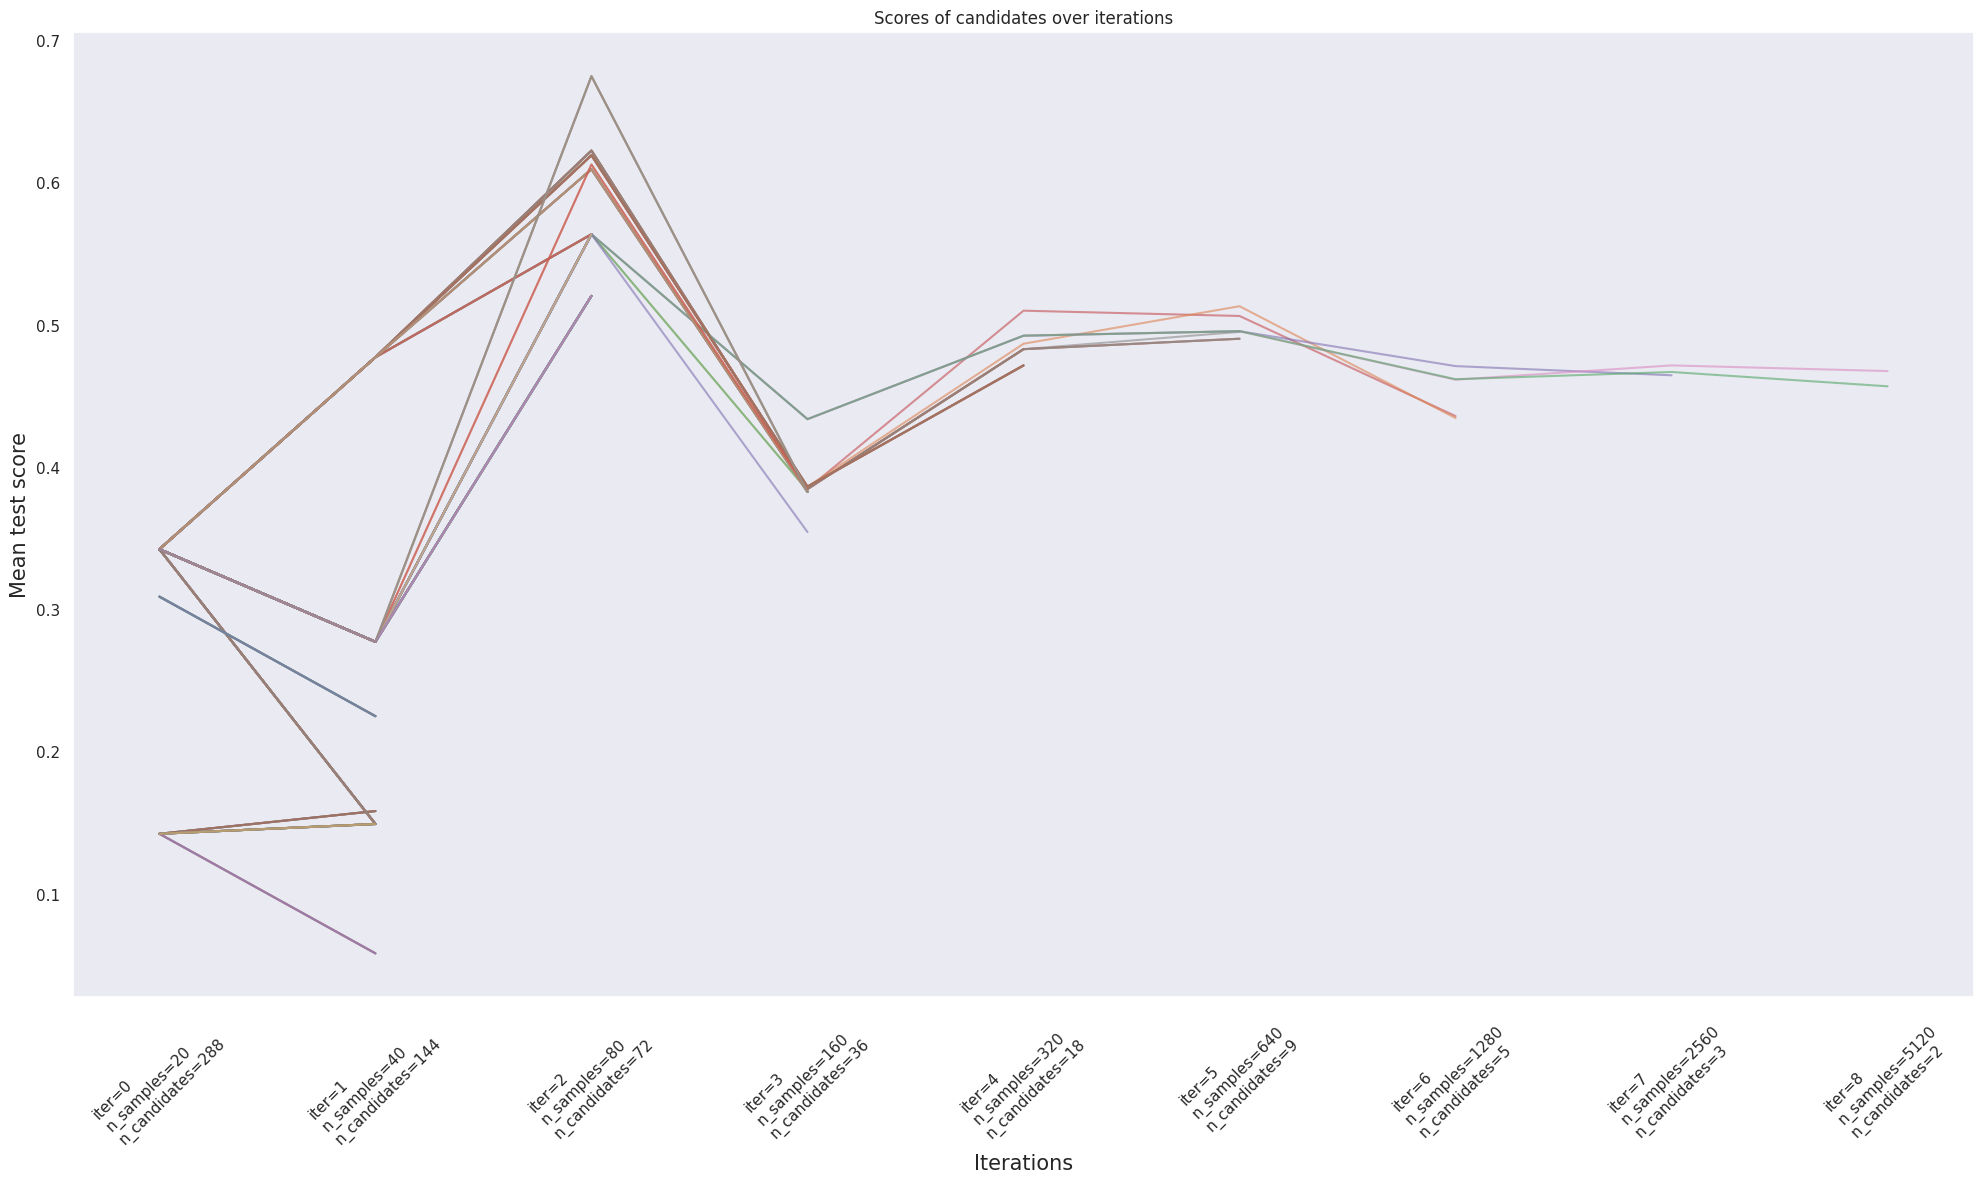

In [ ]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter",
    columns="params_str",
     values="mean_test_score",
)

ax = mean_scores.plot(figsize=(20, 12), legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]

ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
y_preds_rf = rsh.predict(X_test)

Accuracy for RandomForest: 0.8260710568511069
F1-score (recall bias) for RandomForest: 0.30292736241987417
AUC for RandomForest: 0.8412306097006436


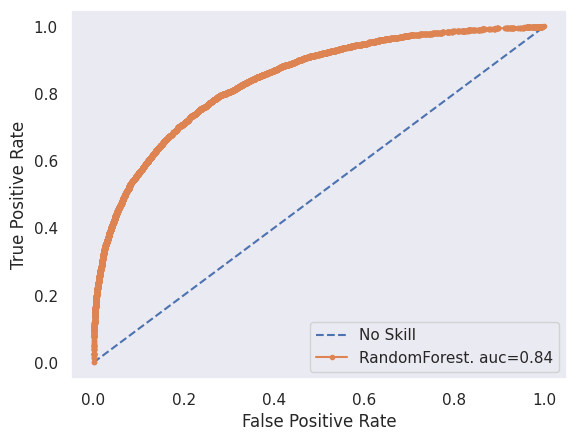

In [ ]:
metrics(rsh, X_test, y_test, y_preds_rf, "RandomForest")

В ДЗ2 пробовали сделать обычное дерево решений, то дерево решений дало лучший f1-score beta=2 ~ 0.31

Предположение: лес переобучился. Возможно, об этом говорит сравнение метрики на валидационной выборке и на тестовой: 0.46 и 0.3

Посмотрим еще в optuna
UPD: также, возможно, сказался дисбаланс классов

## Градиентный бустинг


Воспользуемся следующим алгоритмом для подбора параметров:
- Случайно ищем оптимальные гиперпараметры с фиксированным небольшим числом деревьев
- Фиксируем оптимальные гиперпараметры, тюним количество деревьев


Оптимизируем следующие параметры:
- n_estimators - количество итераций, сколько раз модель будет исправляться. маленькое значение - недобучение, большое - переобучение
- max_depth - максимальная глубина каждого дерева.
- learning_rate - вклад каждой модели, маленькое значение - недобучение, большое - переобучение
- colsample_bytree - доля признаков. Влияет на корреляцию моделей ансмабля, но также важно и не недоубучиться
- subsample - доля выборки. Влияет на корреляцию моделей ансмабля



In [ ]:
pipeline_xgb = Pipeline([
      ('Preprocessing', preprocessing),
      ("model", XGBClassifier(random_state=random_state))
])

In [ ]:
param_dist = {
    'model__n_estimators': [50],
    'model__max_depth': list(range(3, 10)),
    'model__subsample': np.linspace(0.7, 1, 5),
    'model__learning_rate': np.linspace(0.01, 0.3, 7),
    'model__colsample_bytree': np.linspace(0.5, 1, 5),
    'model__random_state': [random_state]
}

f2_scorer = make_scorer(fbeta_score, beta=beta)

random_search = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param_dist,
    n_iter=20,
    random_state=random_state,
    n_jobs=-1,
    scoring=f2_scorer,
    verbose=1
)

In [ ]:
%%time

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 9.32 s, sys: 878 ms, total: 10.2 s
Wall time: 2min 35s


RandomizedSearchCV(estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('Imputation',
                                                                                                SimpleImputer())]),
                                                                               Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm'...
                   param_distributions={'model__colsample_bytree': array([0.5  , 0.625, 0.75 , 0.875, 1.   ]),
                                        'model__learning_rate': array([0.01      , 0.05833333, 0.10666667, 0.155     , 0.20333333,
       0.25166667, 0.3       ]),
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9],
                                        'model__n_estimators': [50],
                                        'model__random_state': [2024],
                                        'model__subsample': array([0.7  , 0.775, 0.85 , 0.925, 1.   ])},
                   random_state=2024,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=1)

In [ ]:
random_search.best_params_

{'model__subsample': 0.925,
 'model__random_state': 2024,
 'model__n_estimators': 50,
 'model__max_depth': 9,
 'model__learning_rate': 0.10666666666666666,
 'model__colsample_bytree': 0.75}

In [ ]:
random_search.best_score_

0.628769070256047

Тюним количество деревьев

In [ ]:
param_dist = random_search.best_params_.copy()
for key, value in param_dist.items():
  param_dist[key] = [value] if not isinstance(value, list) else value
param_dist['model__n_estimators'] = list(np.arange(50, 300, 10))

f2_scorer = make_scorer(fbeta_score, beta=beta)

random_search_trees = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param_dist,
    n_iter=20,
    random_state=random_state,
    n_jobs=-1,
    scoring=f2_scorer,
    verbose=1
)

In [ ]:
%%time

random_search_trees.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 11.6 s, sys: 1.27 s, total: 12.9 s
Wall time: 5min 26s


RandomizedSearchCV(estimator=Pipeline(steps=[('Preprocessing',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('Imputation',
                                                                                                SimpleImputer())]),
                                                                               Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm'...
                   param_distributions={'model__colsample_bytree': [0.75],
                                        'model__learning_rate': [0.10666666666666666],
                                        'model__max_depth': [9],
                                        'model__n_estimators': [50, 60, 70, 80,
                                                                90, 100, 110,
                                                                120, 130, 140,
                                                                150, 160, 170,
                                                                180, 190, 200,
                                                                210, 220, 230,
                                                                240, 250, 260,
                                                                270, 280, 290],
                                        'model__random_state': [2024],
                                        'model__subsample': [0.925]},
                   random_state=2024,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=1)

In [ ]:
random_search_trees.best_params_

{'model__subsample': 0.925,
 'model__random_state': 2024,
 'model__n_estimators': 60,
 'model__max_depth': 9,
 'model__learning_rate': 0.10666666666666666,
 'model__colsample_bytree': 0.75}

In [ ]:
random_search_trees.best_score_

0.6168509064248073

На n_estimators=50 было лучше. Рандомом это число не попало
Будем использовать модель из random_search

In [ ]:
y_preds_xgb = random_search.predict(X_test)

Accuracy for XGB: 0.44161579791274014
F1-score (recall bias) for XGB: 0.629759812536614
AUC for XGB: 0.6982444187480966


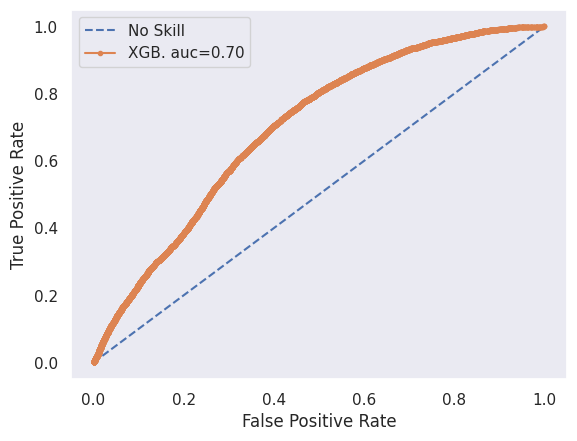

In [ ]:
metrics(random_search, X_test, y_test, y_preds_xgb, "XGB")

Очень хорошая F1-меры, но accuracy оставляет желать лучшего. Возможно дело в дисбалансе классов
Также f1 не учитывает истинно отрицательные примеры, поэтому модель просто подстроилась под метрику

<Axes: xlabel='RainTomorrow'>

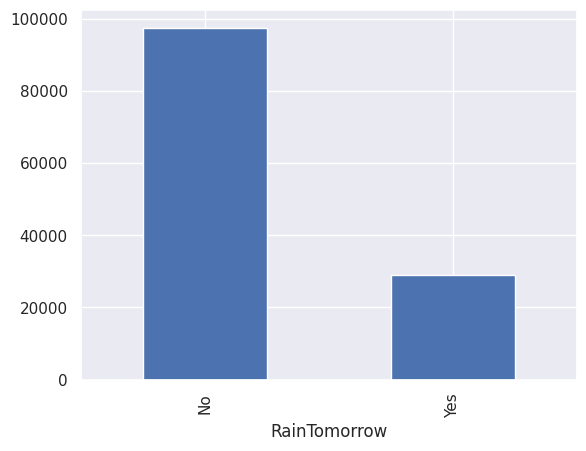

In [ ]:
original_df.groupby("RainTomorrow").size().plot(kind='bar')

Сделаем классы сбалансированными

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=random_state)

## Optuna

In [ ]:
def objective(trial):
    model_choice = trial.suggest_categorical('model_choice', ['RandomForest', 'XGBoost'])

    if model_choice == 'RandomForest':
        params = {
            'model__n_estimators': trial.suggest_int('model__rf_n_estimators', 50, 150, step=20),
            'model__max_depth': trial.suggest_categorical('model__rf_max_depth', list(range(10, 30, 3)) + [None]),
            'model__max_features': trial.suggest_categorical('model__rf_max_features', [
                int(0.5 * np.sqrt(X_train.shape[1])),
                int(np.sqrt(X_train.shape[1])),
                int(2 * np.sqrt(X_train.shape[1]))
            ]),
            'model__criterion': trial.suggest_categorical('model__rf_criterion', ['gini', 'entropy']),
            'model__random_state': random_state
        }
        pipeline_rf.set_params(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        f2_scores = cross_val_score(pipeline_rf, X_train, y_train, cv=cv, scoring=f2_scorer)
        return np.mean(f2_scores)

    else:
        params = {
            'model__n_estimators': trial.suggest_int('model__xgb_n_estimators', 50, 150, step=20),
            'model__max_depth': trial.suggest_int('model__xgb_max_depth', 3, 10),
            'model__subsample': trial.suggest_float('model__xgb_subsample', 0.7, 1, step=0.1),
            'model__learning_rate': trial.suggest_float('model__xgb_learning_rate', 0.01, 0.3, step=0.05),
            'model__colsample_bytree': trial.suggest_float('model__xgb_colsample_bytree', 0.5, 1, step=0.1),
            'model__random_state': random_state
        }
        pipeline_xgb.set_params(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        f2_scores = cross_val_score(pipeline_xgb, X_train, y_train, cv=cv, scoring=f2_scorer)
        return np.mean(f2_scores)

In [ ]:
%%time

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best parameters:", study.best_params)
print("Best F1 score (beta=2):", study.best_value)

Best parameters: {'model_choice': 'RandomForest', 'model__rf_n_estimators': 130, 'model__rf_max_depth': 22, 'model__rf_max_features': 9, 'model__rf_criterion': 'gini'}
Best F1 score (beta=2): 0.8283347841733087
CPU times: user 4min 45s, sys: 6.44 s, total: 4min 51s
Wall time: 3min 11s


In [ ]:
best_params = study.best_params

if best_params['model_choice'] == 'RandomForest':
    # Используем лучшие параметры для RandomForest
    model = RandomForestClassifier(
        random_state=random_state,
        n_estimators=best_params['model__rf_n_estimators'],
        max_depth=best_params['model__rf_max_depth'],
        max_features=best_params['model__rf_max_features'],
        criterion=best_params['model__rf_criterion']
    )

elif best_params['model_choice'] == 'XGBoost':
    # Используем лучшие параметры для XGBoost
    model = XGBClassifier(
        random_state=random_state,
        n_estimators=best_params['model__xgb_n_estimators'],
        max_depth=best_params['model__xgb_max_depth'],
        subsample=best_params['model__xgb_subsample'],
        learning_rate=best_params['model__xgb_learning_rate'],
        colsample_bytree=best_params['model__xgb_colsample_bytree'],
    )

Победил случайный лес

In [ ]:
model

RandomForestClassifier(max_depth=22, max_features=9, n_estimators=130,
                       random_state=2024)

In [ ]:
final_pipeline = Pipeline([
    ('Preprocessing', preprocessing),
    ('model', model)
])

In [ ]:
%%time

final_pipeline.fit(X_train, y_train)

CPU times: user 46.1 s, sys: 193 ms, total: 46.3 s
Wall time: 1min 24s


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer())]),
                                                  Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday_Yes'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('Imputation',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('TargetEncoding',
                                                                   LeaveOneOutEncoder())]),
                                                  Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object'))])),
                ('model',
                 RandomForestClassifier(max_depth=22, max_features=9,
                                        n_estimators=130, random_state=2024))])

In [ ]:
y_preds_best = final_pipeline.predict(X_test)

Accuracy for Best: 0.7719007121620687
F1-score (recall bias) for Best: 0.807984279099817
AUC for Best: 0.8539941240119787


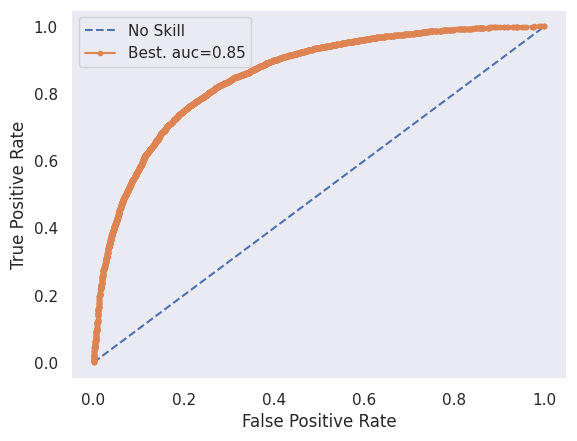

In [ ]:
metrics(final_pipeline, X_test, y_test, y_preds_best, "Best")

## Интерпретация полученной модель

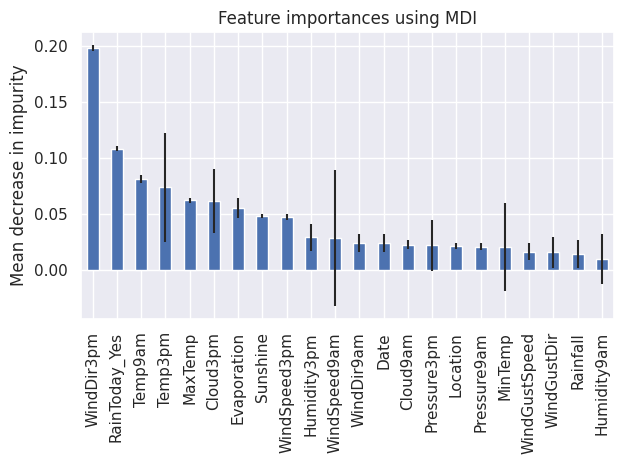

In [ ]:
forest_importances = pd.Series(final_pipeline['model'].feature_importances_, index=X_train.columns)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in final_pipeline['model'].estimators_], axis=0)
forest_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", )
fig.tight_layout()

Как и ожидалось - направление ветра и "был ли дождь сегодня" - это важные признаки

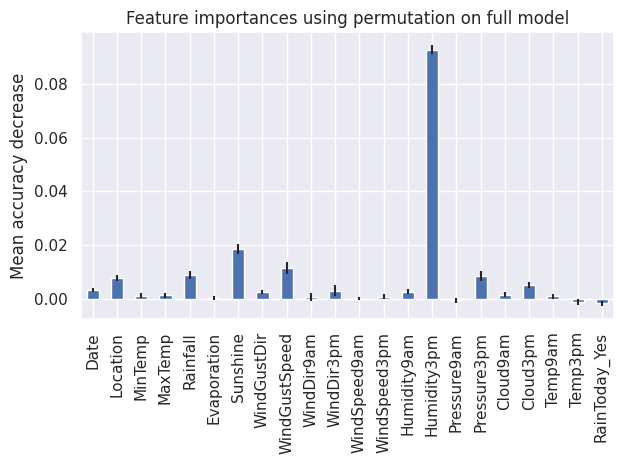

In [ ]:
from sklearn.inspection import permutation_importance

importances = permutation_importance(final_pipeline, X_test, y_test, n_repeats=10, random_state=random_state, n_jobs=2, scoring=f2_scorer)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Уровень облачности тоже очень важен, но вот почему так сильно отличаются графики? Что с этим делать? Есть ли какие-то проблемы?

In [ ]:
# !pip install lime
from lime import lime_tabular

X_train_transformed = final_pipeline['Preprocessing'].transform(X_train)

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=final_pipeline['Preprocessing'].get_feature_names_out())
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_transformed_df.values,
    feature_names=X_train.columns,
    class_names=['RainTomorrow_Yes'],
    verbose=True,
    mode='classification'
)
i = 33
exp = explainer.explain_instance(X_train_transformed_df.iloc[i].values, final_pipeline['model'].predict_proba, num_features=5);

Intercept 0.6607641157425508
Prediction_local [0.27076121]
Right: 0.0008694274279069519


In [ ]:
exp.show_in_notebook(show_table=True)

На локальном примере получили похожие важные признаки, что и при feature_importances_

## Небольшие выводы

Лучшая модель была выбрана с помощью Optuna - случайный лес. В данных присутствовало немало шума, поэтому хорошими оказались деревья с небольшой глубиной. Также стоит попробовать улучшить модель добавлением в нее деревьев (при оптимизации этого гиперпараметра было взято макс. значение).

Почему тогда при первом подборе получили не качественную модель? Скорее всего, повлиял дисбаланс классов, который негативно может влиять на f1-меру (в Optuna от него впоследствии избавились). Также, возможно, HalvingRandomSearchCV выбрал "неудачные данные" данные для лучшей модели, поэтому отсек.

Не получилось настроить бустинг, данная модель подстраивалась под целевую метрику, при этом другие были плохими. Так, например, поиск нашел модель, у которой точность хуже случайной классификации